### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import cal_mape

from utilities import cal_score, convert_types, create_dt_feats

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Params

In [2]:
is_log_target = True
is_per_area_target = True

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

#cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_num_add = ['building_per_land_area']
cols_cat_add = ['encoded_latlon']

#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [3]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
 
    #cols_feats = cols_num + cols_cat + cols_feats_add
    
    return df  #, cols_feats

In [4]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)
    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)

        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)


In [5]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [6]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [7]:
df = pd.read_csv('dataset/train.csv', dtype=object)
df.head(5)

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696


### Preprocessing

In [8]:
df = pre_processing(df, cols_num, cols_cat)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

### Grid search

In [9]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.01 }

lgb_other_params = {'num_boost_round': 20000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000 }

# prvs baseline best estimator
# ('objective', 'mse'), ('metric', 'mape'),
# ('learning_rate', 0.015), ('num_leaves', 255),
# ('feature_fraction', 0.5), ('min_data_in_leaf', 5),
# ('lambda_l1', 0.1), ('lambda_l2', 0.1)),
# 5524.863045737181,
# [5528.862755759428, 5530.862894274216, 5514.863487177898]]

#params_gsearch = {'max_depth':[-1, 8],
#                  'num_leaves': [200, 255]}

params_gsearch = {'max_depth': [-1, 8, 16, 24],
                  'num_leaves': [200, 255, 300],           # may reduce in dim-reduction exp
                  'feature_fraction': [0.5, 0.75, 1.0],
                  'min_data_in_leaf': [5, 10, 20],
                  'lambda_l1': [0, 0.01, 0.1],
                  'lambda_l2': [0, 0.01, 0.1],
                 }
N_fold = 3
N_iter = 100
score_low_bound = 5600 # if score smaller than this, skip the param set

#### Round 1

In [10]:
# Round 1
rand_params_set = []
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)
gsearch = {}

In [11]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_target], reference=lgb_train).construct()
        
    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        params = params_fix.copy()
        params.update( params_rand )

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)

        y_pred = model.predict(df_val[cols_feats])
        mse = mean_squared_error(df_val[col_target], y_pred)
        mae = mean_absolute_error(df_val[col_target], y_pred)
        mape = cal_mape(df_val[col_target], y_pred)
        
        y_pred_final = post_processing(y_pred, df_val)
        score = cal_score(df_val['total_price'], y_pred_final)

        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (score, mse, mae, mape))

        if score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(model.best_iteration)
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0098207
[4000]	valid_0's mape: 0.00963308
[6000]	valid_0's mape: 0.00958557
[8000]	valid_0's mape: 0.00956667
[10000]	valid_0's mape: 0.00955872
[12000]	valid_0's mape: 0.00955454
[14000]	valid_0's mape: 0.00955263
[16000]	valid_0's mape: 0.00955088
[18000]	valid_0's mape: 0.00954991
[20000]	valid_0's mape: 0.00954921
Did not meet early stopping. Best iteration is:
[19999]	valid_0's mape: 0.00954921
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 20, 'lambda_l1': 0.01, 'lambda_l2': 0.0}
score, mse, mae, mape: 5706.86781, 0.03887, 0.12685, 0.00954.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00972355
[4000]	valid_0's mape: 0.00952162
[6000]	valid_0's mape: 0.0094683
[8000]	valid_0's mape: 0.0094

[2000]	valid_0's mape: 0.0104494
[4000]	valid_0's mape: 0.0100429
[6000]	valid_0's mape: 0.00986234
[8000]	valid_0's mape: 0.00977561
[10000]	valid_0's mape: 0.0097239
[12000]	valid_0's mape: 0.0096899
[14000]	valid_0's mape: 0.00966663
[16000]	valid_0's mape: 0.00965189
[18000]	valid_0's mape: 0.00964071
[20000]	valid_0's mape: 0.00963628
Did not meet early stopping. Best iteration is:
[19985]	valid_0's mape: 0.00963626
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 300, 'feature_fraction': 0.75, 'min_data_in_leaf': 20, 'lambda_l1': 0.0, 'lambda_l2': 0.01}
score, mse, mae, mape: 5605.86668, 0.03881, 0.12802, 0.00962.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00989973
[4000]	valid_0's mape: 0.00972972
[6000]	valid_0's mape: 0.00969
[8000]	valid_0's mape: 0.00967418
[10000]	valid_0's mape: 0.0096681
[12000]	valid_0's mape: 0.00966412
[14000]	valid

[2000]	valid_0's mape: 0.0097397
[4000]	valid_0's mape: 0.00953093
[6000]	valid_0's mape: 0.00947312
[8000]	valid_0's mape: 0.00945248
[10000]	valid_0's mape: 0.00944241
[12000]	valid_0's mape: 0.00943787
[14000]	valid_0's mape: 0.00943448
[16000]	valid_0's mape: 0.00943334
Early stopping, best iteration is:
[15553]	valid_0's mape: 0.00943334
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': -1, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 10, 'lambda_l1': 0.1, 'lambda_l2': 0.01}
score, mse, mae, mape: 5736.86930, 0.03826, 0.12542, 0.00943.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00974392
[4000]	valid_0's mape: 0.00955101
[6000]	valid_0's mape: 0.00949277
[8000]	valid_0's mape: 0.009469
[10000]	valid_0's mape: 0.00945882
[12000]	valid_0's mape: 0.00945364
[14000]	valid_0's mape: 0.00945074
[16000]	valid_0's mape: 0.00944917
[18000]	valid_0's map

[2000]	valid_0's mape: 0.0097024
[4000]	valid_0's mape: 0.00950599
[6000]	valid_0's mape: 0.00945672
[8000]	valid_0's mape: 0.0094376
[10000]	valid_0's mape: 0.00942961
[12000]	valid_0's mape: 0.00942535
[14000]	valid_0's mape: 0.00942365
Early stopping, best iteration is:
[13577]	valid_0's mape: 0.00942365
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 300, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.01}
score, mse, mae, mape: 5752.86939, 0.03829, 0.12529, 0.00942.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0105966
[4000]	valid_0's mape: 0.0102004
[6000]	valid_0's mape: 0.0100231
[8000]	valid_0's mape: 0.00992595
[10000]	valid_0's mape: 0.00987164
[12000]	valid_0's mape: 0.00983721
[14000]	valid_0's mape: 0.00981716
[16000]	valid_0's mape: 0.00980402
[18000]	valid_0's mape: 0.00979662
[20000]	valid_0's mape: 

[2000]	valid_0's mape: 0.0103122
[4000]	valid_0's mape: 0.00991673
[6000]	valid_0's mape: 0.00976372
[8000]	valid_0's mape: 0.00968492
[10000]	valid_0's mape: 0.00963438
[12000]	valid_0's mape: 0.00960646
[14000]	valid_0's mape: 0.00959018
[16000]	valid_0's mape: 0.00957819
[18000]	valid_0's mape: 0.00956949
[20000]	valid_0's mape: 0.00956338
Did not meet early stopping. Best iteration is:
[19999]	valid_0's mape: 0.00956338
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 5, 'lambda_l1': 0.0, 'lambda_l2': 0.0}
score, mse, mae, mape: 5651.86757, 0.03875, 0.12708, 0.00955.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0099227
[4000]	valid_0's mape: 0.00973329
[6000]	valid_0's mape: 0.00968158
[8000]	valid_0's mape: 0.00965851
[10000]	valid_0's mape: 0.00964807
[12000]	valid_0's mape: 0.00964201
[14000]	v

params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': -1, 'num_leaves': 200, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0.0, 'lambda_l2': 0.0}
score, mse, mae, mape: 5716.86934, 0.03799, 0.12534, 0.00942.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00990584
[4000]	valid_0's mape: 0.00967167
[6000]	valid_0's mape: 0.00960301
[8000]	valid_0's mape: 0.00957452
[10000]	valid_0's mape: 0.00956086
[12000]	valid_0's mape: 0.00955357
[14000]	valid_0's mape: 0.00954992
[16000]	valid_0's mape: 0.00954775
[18000]	valid_0's mape: 0.00954616
[20000]	valid_0's mape: 0.00954501
Did not meet early stopping. Best iteration is:
[19985]	valid_0's mape: 0.009545
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': -1, 'num_leaves': 200, 'feature_fraction': 0.75, 'min_data_in_leaf': 20, 'lambda_l1': 0.0

[8000]	valid_0's mape: 0.00946578
[10000]	valid_0's mape: 0.00945892
[12000]	valid_0's mape: 0.00945567
[14000]	valid_0's mape: 0.00945354
[16000]	valid_0's mape: 0.00945248
[18000]	valid_0's mape: 0.00945169
[20000]	valid_0's mape: 0.00945109
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00945109
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 300, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0.0, 'lambda_l2': 0.01}
score, mse, mae, mape: 5726.86901, 0.03836, 0.12567, 0.00945.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0100395
[4000]	valid_0's mape: 0.0097923
[6000]	valid_0's mape: 0.00970847
[8000]	valid_0's mape: 0.00967705
[10000]	valid_0's mape: 0.00966008
[12000]	valid_0's mape: 0.00965148
[14000]	valid_0's mape: 0.00964593
[16000]	valid_0's mape: 0.00964276
[18000]	valid_0's mape: 0.00964043
[200

[2000]	valid_0's mape: 0.00980383
[4000]	valid_0's mape: 0.00960038
[6000]	valid_0's mape: 0.00954291
[8000]	valid_0's mape: 0.00952
[10000]	valid_0's mape: 0.009509
[12000]	valid_0's mape: 0.00950322
[14000]	valid_0's mape: 0.00949993
[16000]	valid_0's mape: 0.00949796
[18000]	valid_0's mape: 0.00949683
[20000]	valid_0's mape: 0.00949606
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00949606
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': -1, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 5, 'lambda_l1': 0.01, 'lambda_l2': 0.01}
score, mse, mae, mape: 5722.86853, 0.03860, 0.12619, 0.00949.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00999334
[4000]	valid_0's mape: 0.00975746
[6000]	valid_0's mape: 0.00968442
[8000]	valid_0's mape: 0.0096539
[10000]	valid_0's mape: 0.00963794
[12000]	valid_0's mape: 0.00962998
[14000]	va

[2000]	valid_0's mape: 0.0104508
[4000]	valid_0's mape: 0.0100374
[6000]	valid_0's mape: 0.00986218
[8000]	valid_0's mape: 0.00977617
[10000]	valid_0's mape: 0.00972047
[12000]	valid_0's mape: 0.00968575
[14000]	valid_0's mape: 0.00966622
[16000]	valid_0's mape: 0.00965312
[18000]	valid_0's mape: 0.0096436
[20000]	valid_0's mape: 0.0096374
Did not meet early stopping. Best iteration is:
[19990]	valid_0's mape: 0.00963736
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 200, 'feature_fraction': 0.75, 'min_data_in_leaf': 20, 'lambda_l1': 0.0, 'lambda_l2': 0.0}
score, mse, mae, mape: 5606.86654, 0.03874, 0.12805, 0.00963.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0104764
[4000]	valid_0's mape: 0.0100771
[6000]	valid_0's mape: 0.00989914
[8000]	valid_0's mape: 0.00980439
[10000]	valid_0's mape: 0.00976034
[12000]	valid_0's mape: 0.0097312
[14000]	valid

[2000]	valid_0's mape: 0.00976318
[4000]	valid_0's mape: 0.00959046
[6000]	valid_0's mape: 0.00954366
[8000]	valid_0's mape: 0.00952531
[10000]	valid_0's mape: 0.00951682
[12000]	valid_0's mape: 0.00951265
[14000]	valid_0's mape: 0.0095105
[16000]	valid_0's mape: 0.00950926
[18000]	valid_0's mape: 0.00950853
[20000]	valid_0's mape: 0.00950806
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00950806
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 300, 'feature_fraction': 0.75, 'min_data_in_leaf': 5, 'lambda_l1': 0.01, 'lambda_l2': 0.1}
score, mse, mae, mape: 5696.86824, 0.03883, 0.12635, 0.00950.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00982953
[4000]	valid_0's mape: 0.00956865
[6000]	valid_0's mape: 0.00948497
[8000]	valid_0's mape: 0.00945119
[10000]	valid_0's mape: 0.00943388
[12000]	valid_0's mape: 0.00942459
[14000

params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 10, 'lambda_l1': 0.0, 'lambda_l2': 0.0}
score, mse, mae, mape: 5644.86821, 0.04046, 0.12836, 0.00963.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0100003
[4000]	valid_0's mape: 0.00981061
[6000]	valid_0's mape: 0.00975804
[8000]	valid_0's mape: 0.00973474
[10000]	valid_0's mape: 0.00972371
[12000]	valid_0's mape: 0.00971771
[14000]	valid_0's mape: 0.00971434
[16000]	valid_0's mape: 0.00971316
Early stopping, best iteration is:
[15205]	valid_0's mape: 0.00971316
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 10, 'lambda_l1': 0.1, 'lambda_l2': 0.0}
score, mse, mae, mape: 5681.86692, 0.04167, 0.12924, 0.00969.
T

[18000]	valid_0's mape: 0.00946542
[20000]	valid_0's mape: 0.00946344
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00946344
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 200, 'feature_fraction': 0.5, 'min_data_in_leaf': 10, 'lambda_l1': 0.01, 'lambda_l2': 0.0}
score, mse, mae, mape: 5748.87062, 0.03984, 0.12599, 0.00945.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00976686
[4000]	valid_0's mape: 0.00960887
[6000]	valid_0's mape: 0.00956642
[8000]	valid_0's mape: 0.0095493
[10000]	valid_0's mape: 0.00954165
[12000]	valid_0's mape: 0.0095379
[14000]	valid_0's mape: 0.00953578
[16000]	valid_0's mape: 0.00953463
[18000]	valid_0's mape: 0.00953388
[20000]	valid_0's mape: 0.00953343
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00953343
params: {'task': 'train', 'boosting_type': 'gbdt', 'objectiv

[14000]	valid_0's mape: 0.00971409
[16000]	valid_0's mape: 0.00971084
[18000]	valid_0's mape: 0.00970876
Early stopping, best iteration is:
[18922]	valid_0's mape: 0.00970799
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 200, 'feature_fraction': 1.0, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.1}
score, mse, mae, mape: 5658.86737, 0.04142, 0.12910, 0.00968.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00972909
[4000]	valid_0's mape: 0.00955429
[6000]	valid_0's mape: 0.00950708
[8000]	valid_0's mape: 0.00948785
[10000]	valid_0's mape: 0.0094776
[12000]	valid_0's mape: 0.00947265
[14000]	valid_0's mape: 0.00947017
Early stopping, best iteration is:
[13970]	valid_0's mape: 0.00947017
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 300, 'feature_

[10000]	valid_0's mape: 0.00970974
[12000]	valid_0's mape: 0.00970464
[14000]	valid_0's mape: 0.00970192
[16000]	valid_0's mape: 0.00970007
[18000]	valid_0's mape: 0.0096989
[20000]	valid_0's mape: 0.00969809
Did not meet early stopping. Best iteration is:
[19999]	valid_0's mape: 0.00969809
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 10, 'lambda_l1': 0.01, 'lambda_l2': 0.01}
score, mse, mae, mape: 5654.86719, 0.04152, 0.12906, 0.00968.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0103387
[4000]	valid_0's mape: 0.00996743
[6000]	valid_0's mape: 0.00981602
[8000]	valid_0's mape: 0.00974066
[10000]	valid_0's mape: 0.00969906
[12000]	valid_0's mape: 0.00967181
[14000]	valid_0's mape: 0.00965636
[16000]	valid_0's mape: 0.00964342
[18000]	valid_0's mape: 0.00963448
[20000]	valid_0's mape: 0.00962886
Di

[2000]	valid_0's mape: 0.0100158
[4000]	valid_0's mape: 0.00982339
[6000]	valid_0's mape: 0.00976849
[8000]	valid_0's mape: 0.00974333
[10000]	valid_0's mape: 0.00973151
[12000]	valid_0's mape: 0.00972571
[14000]	valid_0's mape: 0.00972228
[16000]	valid_0's mape: 0.00971997
[18000]	valid_0's mape: 0.00971859
[20000]	valid_0's mape: 0.00971777
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00971777
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 5, 'lambda_l1': 0.0, 'lambda_l2': 0.01}
score, mse, mae, mape: 5648.86725, 0.04191, 0.12932, 0.00970.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00997859
[4000]	valid_0's mape: 0.00979897
[6000]	valid_0's mape: 0.00974275
[8000]	valid_0's mape: 0.00971989
[10000]	valid_0's mape: 0.00970925
[12000]	valid_0's mape: 0.00970379
[14000]

[2000]	valid_0's mape: 0.0097105
[4000]	valid_0's mape: 0.00954231
[6000]	valid_0's mape: 0.00949869
[8000]	valid_0's mape: 0.00948147
[10000]	valid_0's mape: 0.00947298
[12000]	valid_0's mape: 0.00946817
[14000]	valid_0's mape: 0.00946639
Early stopping, best iteration is:
[13620]	valid_0's mape: 0.00946639
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 300, 'feature_fraction': 0.5, 'min_data_in_leaf': 10, 'lambda_l1': 0.1, 'lambda_l2': 0.0}
score, mse, mae, mape: 5756.87062, 0.04004, 0.12607, 0.00946.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00977738
[4000]	valid_0's mape: 0.00961478
[6000]	valid_0's mape: 0.00957043
[8000]	valid_0's mape: 0.00955113
[10000]	valid_0's mape: 0.00954264
[12000]	valid_0's mape: 0.00953875
[14000]	valid_0's mape: 0.00953645
[16000]	valid_0's mape: 0.00953519
[18000]	valid_0's mape: 0.00953444
[20000]	valid_0's ma

[2000]	valid_0's mape: 0.0103784
[4000]	valid_0's mape: 0.0100042
[6000]	valid_0's mape: 0.00984845
[8000]	valid_0's mape: 0.00976946
[10000]	valid_0's mape: 0.0097257
[12000]	valid_0's mape: 0.00969883
[14000]	valid_0's mape: 0.00968116
[16000]	valid_0's mape: 0.00966781
[18000]	valid_0's mape: 0.00965942
[20000]	valid_0's mape: 0.00965123
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00965123
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 10, 'lambda_l1': 0.01, 'lambda_l2': 0.0}
score, mse, mae, mape: 5629.86808, 0.04055, 0.12857, 0.00964.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0100437
[4000]	valid_0's mape: 0.0098562
[6000]	valid_0's mape: 0.00980672
[8000]	valid_0's mape: 0.00978961
[10000]	valid_0's mape: 0.00978082
[12000]	valid_0's mape: 0.00977556
[14000]	va

[2000]	valid_0's mape: 0.00992923
[4000]	valid_0's mape: 0.00968595
[6000]	valid_0's mape: 0.00960431
[8000]	valid_0's mape: 0.0095671
[10000]	valid_0's mape: 0.00954928
[12000]	valid_0's mape: 0.00953942
[14000]	valid_0's mape: 0.00953272
[16000]	valid_0's mape: 0.00952829
[18000]	valid_0's mape: 0.00952583
Early stopping, best iteration is:
[18973]	valid_0's mape: 0.00952495
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 200, 'feature_fraction': 0.75, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.1}
score, mse, mae, mape: 5730.86979, 0.04016, 0.12677, 0.00951.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00973309
[4000]	valid_0's mape: 0.00955512
[6000]	valid_0's mape: 0.00950348
[8000]	valid_0's mape: 0.00948373
[10000]	valid_0's mape: 0.00947497
[12000]	valid_0's mape: 0.00947008
[14000]	valid_0's mape: 0.00946674
[16000]	valid_0's ma

[2000]	valid_0's mape: 0.00984347
[4000]	valid_0's mape: 0.00965087
[6000]	valid_0's mape: 0.00959707
[8000]	valid_0's mape: 0.00957247
[10000]	valid_0's mape: 0.00956087
[12000]	valid_0's mape: 0.00955404
[14000]	valid_0's mape: 0.00955031
[16000]	valid_0's mape: 0.00954782
[18000]	valid_0's mape: 0.00954624
[20000]	valid_0's mape: 0.00954529
Did not meet early stopping. Best iteration is:
[19997]	valid_0's mape: 0.00954529
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 300, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0.0, 'lambda_l2': 0.1}
score, mse, mae, mape: 5710.86666, 0.03993, 0.12690, 0.00954.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0104465
[4000]	valid_0's mape: 0.0100288
[6000]	valid_0's mape: 0.00987155
[8000]	valid_0's mape: 0.0097933
[10000]	valid_0's mape: 0.00974914
[12000]	valid_0's mape: 0.0097202
[14000]	va

[2000]	valid_0's mape: 0.0100192
[4000]	valid_0's mape: 0.00976711
[6000]	valid_0's mape: 0.00969107
[8000]	valid_0's mape: 0.00965885
[10000]	valid_0's mape: 0.0096425
[12000]	valid_0's mape: 0.00963289
[14000]	valid_0's mape: 0.0096266
[16000]	valid_0's mape: 0.00962312
[18000]	valid_0's mape: 0.00962091
[20000]	valid_0's mape: 0.00961996
Did not meet early stopping. Best iteration is:
[19554]	valid_0's mape: 0.00961995
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 200, 'feature_fraction': 0.75, 'min_data_in_leaf': 20, 'lambda_l1': 0.1, 'lambda_l2': 0.0}
score, mse, mae, mape: 5684.86562, 0.04046, 0.12788, 0.00961.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0100017
[4000]	valid_0's mape: 0.00985763
[6000]	valid_0's mape: 0.00982199
[8000]	valid_0's mape: 0.0098069
[10000]	valid_0's mape: 0.00979975
[12000]	valid_0's mape: 0.00979617
[14000]	va

[2000]	valid_0's mape: 0.00983924
[4000]	valid_0's mape: 0.00963455
[6000]	valid_0's mape: 0.00957434
[8000]	valid_0's mape: 0.0095481
[10000]	valid_0's mape: 0.0095356
[12000]	valid_0's mape: 0.00952849
[14000]	valid_0's mape: 0.00952429
[16000]	valid_0's mape: 0.00952186
[18000]	valid_0's mape: 0.00952039
[20000]	valid_0's mape: 0.00951938
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00951938
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.01, 'lambda_l2': 0.01}
score, mse, mae, mape: 5732.86760, 0.03984, 0.12657, 0.00952.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.010507
[4000]	valid_0's mape: 0.010103
[6000]	valid_0's mape: 0.00993742
[8000]	valid_0's mape: 0.0098555
[10000]	valid_0's mape: 0.00981084
[12000]	valid_0's mape: 0.00977797
[14000]	vali

[2000]	valid_0's mape: 0.0105905
[4000]	valid_0's mape: 0.0101703
[6000]	valid_0's mape: 0.0100124
[8000]	valid_0's mape: 0.00992798
[10000]	valid_0's mape: 0.00988138
[12000]	valid_0's mape: 0.00984825
[14000]	valid_0's mape: 0.00982221
[16000]	valid_0's mape: 0.00980458
[18000]	valid_0's mape: 0.00979179
[20000]	valid_0's mape: 0.00978623
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.00978623
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 20, 'lambda_l1': 0.0, 'lambda_l2': 0.1}
score, mse, mae, mape: 5636.86349, 0.04122, 0.13000, 0.00977.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.010194
[4000]	valid_0's mape: 0.00994865
[6000]	valid_0's mape: 0.00986848
[8000]	valid_0's mape: 0.00983355
[10000]	valid_0's mape: 0.00981451
[12000]	valid_0's mape: 0.00980444
[14000]	val

[2000]	valid_0's mape: 0.0100542
[4000]	valid_0's mape: 0.00986518
[6000]	valid_0's mape: 0.00981349
[8000]	valid_0's mape: 0.0097934
[10000]	valid_0's mape: 0.00978304
[12000]	valid_0's mape: 0.00977779
[14000]	valid_0's mape: 0.00977497
[16000]	valid_0's mape: 0.00977325
[18000]	valid_0's mape: 0.00977218
[20000]	valid_0's mape: 0.00977146
Did not meet early stopping. Best iteration is:
[19999]	valid_0's mape: 0.00977146
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': -1, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 10, 'lambda_l1': 0.01, 'lambda_l2': 0.0}
score, mse, mae, mape: 5644.86373, 0.04199, 0.12996, 0.00977.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0098566
[4000]	valid_0's mape: 0.00968871
[6000]	valid_0's mape: 0.00964134
[8000]	valid_0's mape: 0.00962394
[10000]	valid_0's mape: 0.00961583
[12000]	valid_0's mape: 0.00961183
[14000]	

params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 300, 'feature_fraction': 1.0, 'min_data_in_leaf': 20, 'lambda_l1': 0.1, 'lambda_l2': 0.01}
score, mse, mae, mape: 5660.86341, 0.04195, 0.13016, 0.00978.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0100503
[4000]	valid_0's mape: 0.00987195
[6000]	valid_0's mape: 0.00981894
[8000]	valid_0's mape: 0.00979915
[10000]	valid_0's mape: 0.00978901
[12000]	valid_0's mape: 0.00978319
[14000]	valid_0's mape: 0.00978046
[16000]	valid_0's mape: 0.00977882
[18000]	valid_0's mape: 0.00977775
[20000]	valid_0's mape: 0.009777
Did not meet early stopping. Best iteration is:
[20000]	valid_0's mape: 0.009777
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': -1, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 10, 'lambda_l1': 0.0, '

[8000]	valid_0's mape: 0.00954521
[10000]	valid_0's mape: 0.00952465
[12000]	valid_0's mape: 0.00951347
[14000]	valid_0's mape: 0.00950763
[16000]	valid_0's mape: 0.00950353
[18000]	valid_0's mape: 0.00950048
[20000]	valid_0's mape: 0.00949897
Did not meet early stopping. Best iteration is:
[19791]	valid_0's mape: 0.00949897
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 200, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.0}
score, mse, mae, mape: 5732.86794, 0.03956, 0.12626, 0.00949.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0103918
[4000]	valid_0's mape: 0.00998489
[6000]	valid_0's mape: 0.00982012
[8000]	valid_0's mape: 0.00973496
[10000]	valid_0's mape: 0.00968486
[12000]	valid_0's mape: 0.00965242
[14000]	valid_0's mape: 0.00962904
[16000]	valid_0's mape: 0.00961176
[18000]	valid_0's mape: 0.009601
[20000]

[2000]	valid_0's mape: 0.00992509
[4000]	valid_0's mape: 0.0096855
[6000]	valid_0's mape: 0.00961433
[8000]	valid_0's mape: 0.00958189
[10000]	valid_0's mape: 0.00956461
[12000]	valid_0's mape: 0.00955734
[14000]	valid_0's mape: 0.00955235
[16000]	valid_0's mape: 0.00954922
[18000]	valid_0's mape: 0.00954686
[20000]	valid_0's mape: 0.00954506
Did not meet early stopping. Best iteration is:
[19994]	valid_0's mape: 0.00954506
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 200, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0.0, 'lambda_l2': 0.1}
score, mse, mae, mape: 5702.86677, 0.03968, 0.12686, 0.00954.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0100115
[4000]	valid_0's mape: 0.00985851
[6000]	valid_0's mape: 0.00981671
[8000]	valid_0's mape: 0.00980028
[10000]	valid_0's mape: 0.0097933
[12000]	valid_0's mape: 0.00978963
Early sto

[2000]	valid_0's mape: 0.00981759
[4000]	valid_0's mape: 0.00962168
[6000]	valid_0's mape: 0.00956868
[8000]	valid_0's mape: 0.00954882
[10000]	valid_0's mape: 0.0095389
[12000]	valid_0's mape: 0.00953331
[14000]	valid_0's mape: 0.00952973
[16000]	valid_0's mape: 0.00952822
Early stopping, best iteration is:
[16327]	valid_0's mape: 0.00952799
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': -1, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0.1, 'lambda_l2': 0.01}
score, mse, mae, mape: 5708.86692, 0.03976, 0.12666, 0.00952.
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00983478
[4000]	valid_0's mape: 0.0096665
[6000]	valid_0's mape: 0.00961991
[8000]	valid_0's mape: 0.00960284
[10000]	valid_0's mape: 0.00959381
[12000]	valid_0's mape: 0.00958934
[14000]	valid_0's mape: 0.0095871
[16000]	valid_0's mape: 0.00958578
[18000]	valid_0's map

In [12]:
print('Total computing time:', t1-t0)

Total computing time: 246092.98679590225


In [20]:
for row in gsearch_results:
    print(*[x for i, x in enumerate(row) if i != 5])

(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.1)) 5751.535824967931 0.039459591923082085 0.125959907917059 0.009462390914125944 [5770.86944761114, 5754.8706573824265, 5728.867369910227] [0.0382864217756967, 0.040082923812621914, 0.04000943018092763] [0.1253218389723916, 0.12601067412902697, 0.12654721064975835] [0.009419859567093113, 0.009451505534179722, 0.009515807641105002]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5746.86905611822 0.03944814028730175 0.12601228627199823 0.009466358691452873 [5748.869273841561, 5756.870616637923, 5734.867277875175] [0.0383090254981925, 0.0400429176004988

In [28]:
metrics = ['score', 'mse', 'mae', 'mape']

In [43]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    result['best_iteration'] = np.mean([m.best_iteration for m in row[5]])
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())+metrics+['best_iteration']]
display(df_gsearch_results)

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,score,mse,mae,mape,best_iteration
0,16,300,0.50,10,0.01,0.10,5751.535825,0.039460,0.125960,0.009462,19996.666667
1,24,300,0.50,10,0.10,0.00,5746.869056,0.039448,0.126012,0.009466,13591.666667
2,16,200,0.50,5,0.10,0.00,5746.536157,0.039083,0.125720,0.009445,19929.333333
3,24,255,0.50,5,0.01,0.01,5745.869333,0.039335,0.125860,0.009456,20000.000000
4,16,300,0.50,5,0.10,0.01,5742.535854,0.039483,0.125996,0.009466,13802.333333
5,16,300,0.50,10,0.10,0.00,5742.535830,0.039411,0.125956,0.009462,14051.000000
6,24,255,0.50,5,0.01,0.10,5742.202722,0.039342,0.125834,0.009453,19999.666667
7,-1,200,0.50,5,0.10,0.01,5738.536115,0.039090,0.125758,0.009448,19961.333333
8,16,300,0.50,20,0.10,0.00,5738.201979,0.039385,0.126309,0.009489,15541.666667
9,-1,300,0.50,20,0.10,0.00,5737.201996,0.039380,0.126249,0.009484,14105.000000


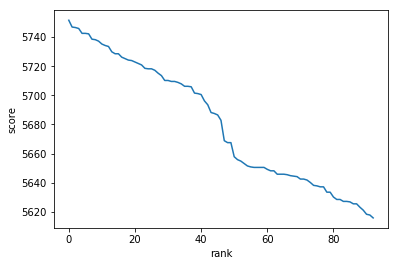

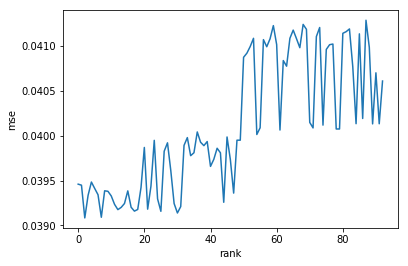

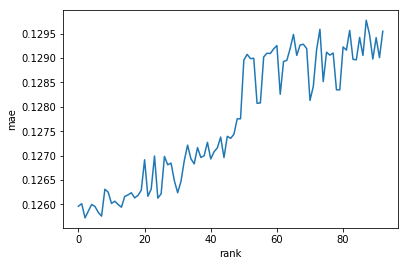

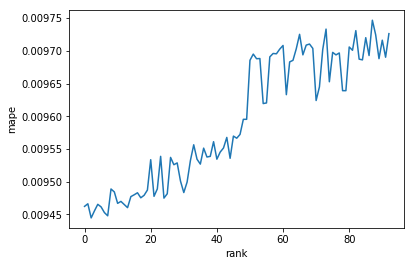

In [31]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

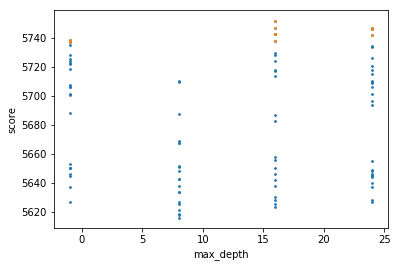

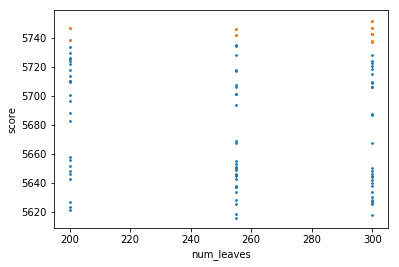

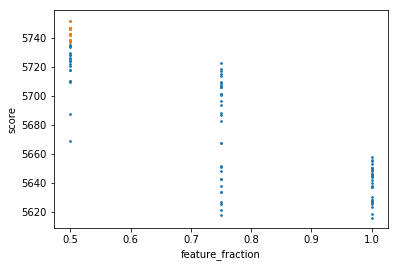

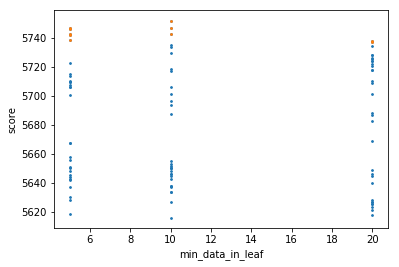

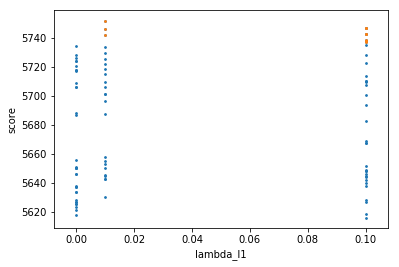

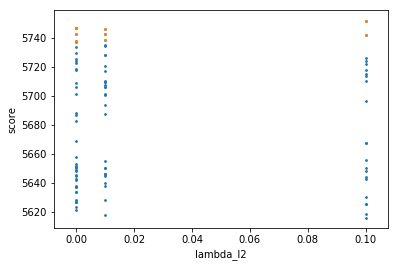

In [41]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['score'][:10], s=3)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

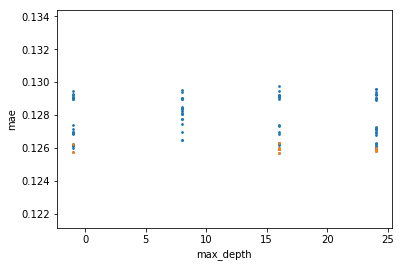

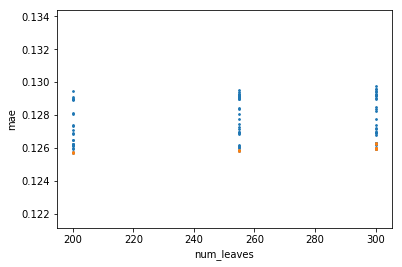

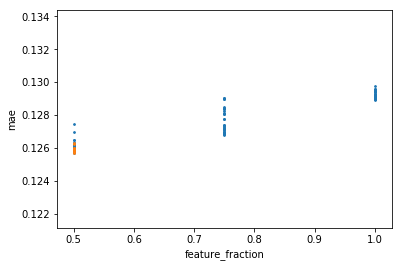

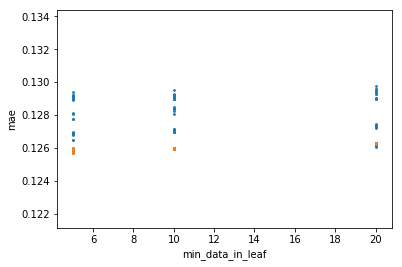

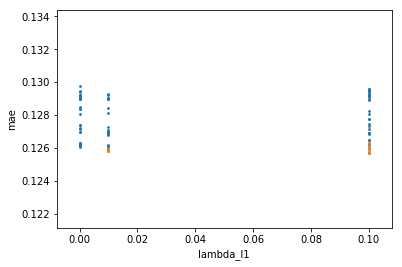

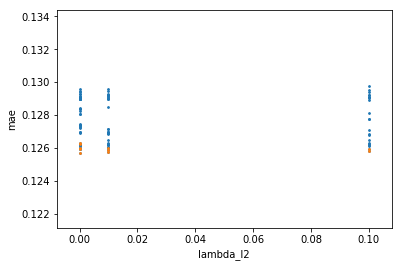

In [42]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=3)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=3)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

In [46]:
df_gsearch_results.columns

Index(['max_depth', 'num_leaves', 'feature_fraction', 'min_data_in_leaf',
       'lambda_l1', 'lambda_l2', 'score', 'mse', 'mae', 'mape',
       'best_iteration'],
      dtype='object')

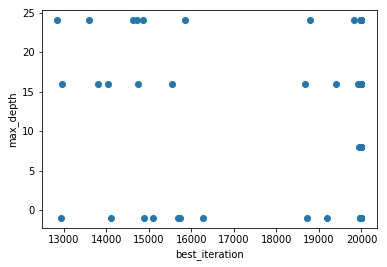

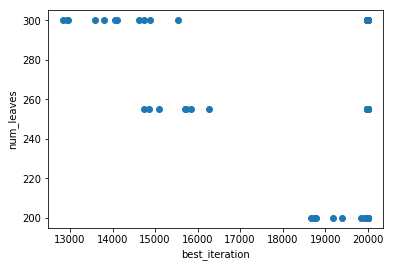

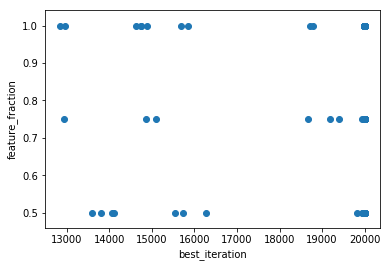

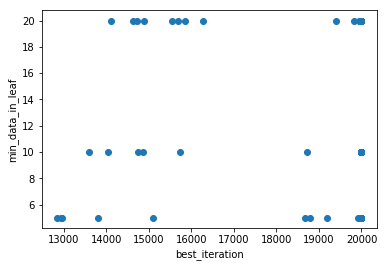

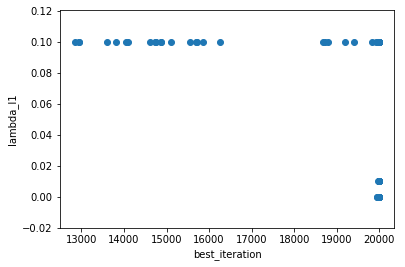

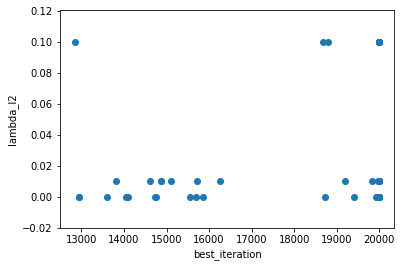

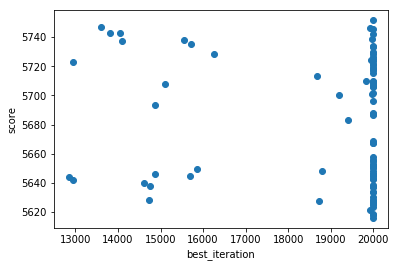

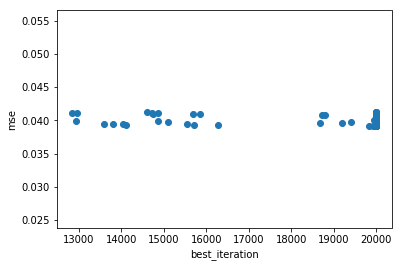

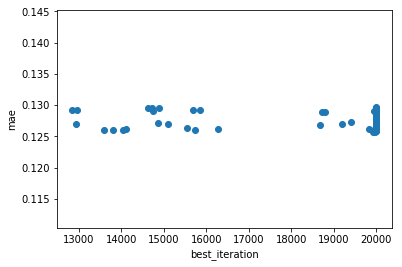

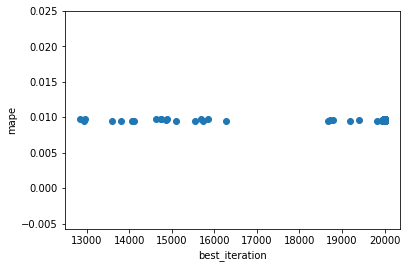

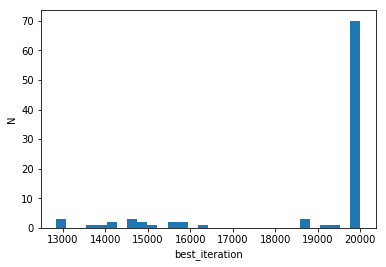

In [48]:
# best iteration
for c in df_gsearch_results.columns:
    if c != 'best_iteration':
        plt.scatter(df_gsearch_results['best_iteration'], df_gsearch_results[c])
        plt.ylabel(c)
    else:
        plt.hist(df_gsearch_results['best_iteration'], bins=30)
        plt.ylabel('N')        
    plt.xlabel('best_iteration')
    plt.show()

### Feature importance

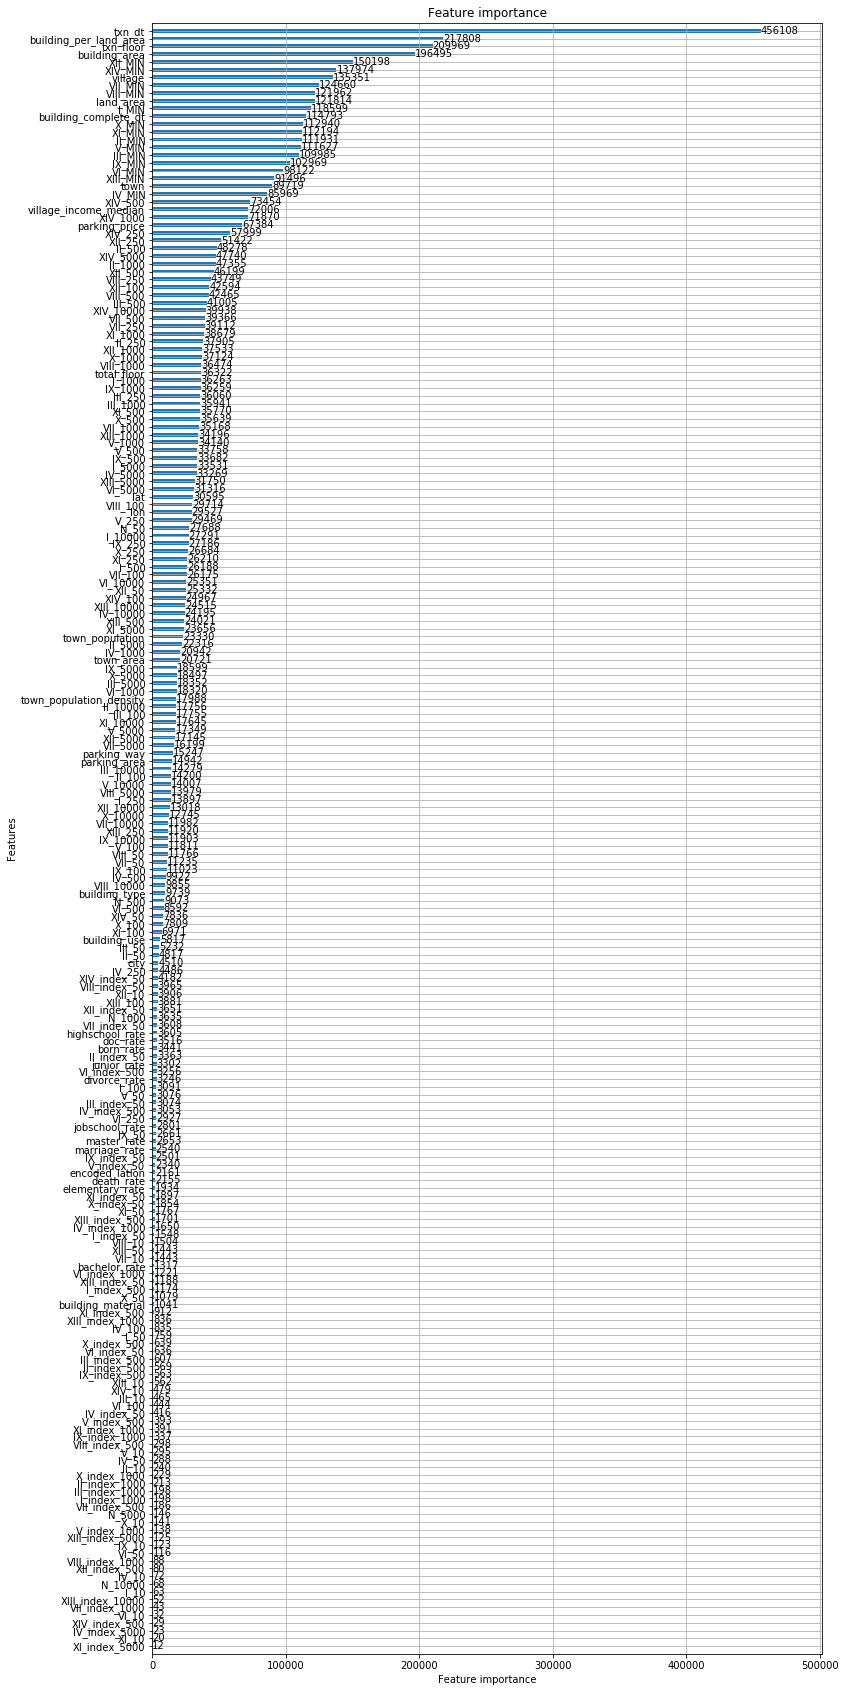

In [14]:
lgb.plot_importance(gsearch_results[0][5][0], figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

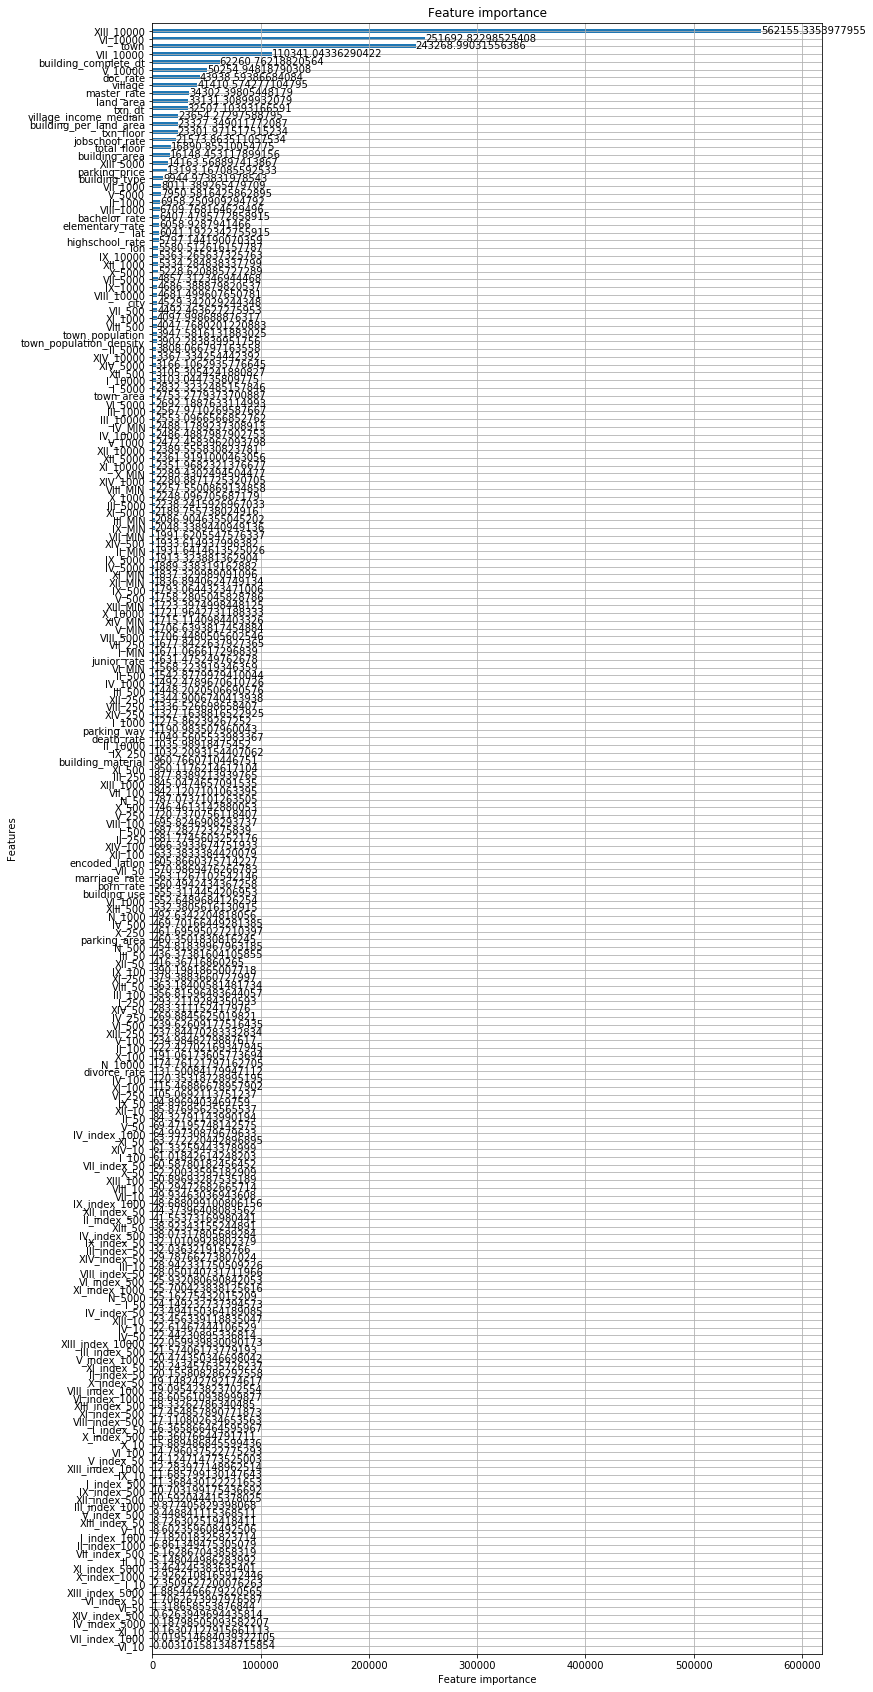

In [15]:
lgb.plot_importance(gsearch_results[0][5][0], figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()

Results:

(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.1)) 5751.535824967931 0.039459591923082085 0.125959907917059 0.009462390914125944 [5770.86944761114, 5754.8706573824265, 5728.867369910227] [0.0382864217756967, 0.040082923812621914, 0.04000943018092763] [0.1253218389723916, 0.12601067412902697, 0.12654721064975835] [0.009419859567093113, 0.009451505534179722, 0.009515807641105002]  
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5746.86905611822 0.03944814028730175 0.12601228627199823 0.009466358691452873 [5748.869273841561, 5756.870616637923, 5734.867277875175] [0.0383090254981925, 0.040042917600498856, 0.03999247776321391] [0.12538597822623734, 0.12607102252769153, 0.12657985806206581] [0.009426286174381128, 0.009455359793958673, 0.00951743010601882]  
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5746.536156947058 0.03908298721976012 0.12572027493260943 0.00944476246575047 [5752.869551814826, 5753.8709839767425, 5732.867935049606] [0.03793472102981275, 0.039756579037145044, 0.03955766159232256] [0.12510107449245353, 0.12579913549430216, 0.12626061481107265] [0.009405316769871315, 0.009434931559292226, 0.009494039068087873]  
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 255), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.01), ('lambda_l2', 0.01)) 5745.869333065994 0.039335218305379026 0.12586015197802028 0.009455554491084952 [5756.869612209503, 5747.870782211299, 5732.867604777181] [0.03812434248011666, 0.04003647899309827, 0.03984483344292214] [0.12506162588799025, 0.12595317854689755, 0.1265656514991731] [0.00940320530028357, 0.00944703183813861, 0.009516426334832673]  
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5742.5358539500185 0.03948331640469078 0.12599573688033136 0.009465538549471105 [5752.869386975002, 5769.87061706571, 5704.8675578093425] [0.03828847545955686, 0.040221424820431444, 0.03994004893408404] [0.12529381544191404, 0.12614762071263808, 0.12654577448644194] [0.009419519391837387, 0.009461654926461185, 0.009515441330114742]  
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5742.535830028061 0.03941143897732297 0.125955552380436 0.00946160810240048 [5758.869525555858, 5769.8707618302715, 5698.867202698055] [0.03828545617668485, 0.03996133972254984, 0.039987521032734216] [0.12516236442298, 0.1259649484014566, 0.12673934431687134] [0.009408460993790693, 0.009446698415337542, 0.009529664898073208]  
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 255), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.01), ('lambda_l2', 0.1)) 5742.202722234534 0.03934154485382709 0.1258343394601633 0.009452945287281564 [5764.8697676102165, 5760.870813342304, 5700.867585751081] [0.038096917400009034, 0.0400854231582602, 0.039842294003212035] [0.12493958997938698, 0.12597079616553777, 0.1265926322355652] [0.009392913543957798, 0.00944784118052776, 0.009518081137359137]  
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5738.536115406435 0.03909020391133924 0.12575766847575764 0.009448008435081277 [5728.869526450998, 5743.871000245712, 5742.867819522595] [0.03788339397108342, 0.03980528193526395, 0.03958193582767033] [0.12509740464225627, 0.12575551202629645, 0.1264200887587202] [0.00940564110907069, 0.00943230911613438, 0.009506075080038761]  
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5738.201978846125 0.039385459819969715 0.12630885649675194 0.009488949903024227 [5762.86921354735, 5750.869925799352, 5700.866797191672] [0.03820052277395741, 0.040083502580681114, 0.03987235410527063] [0.12550085970450214, 0.1265920932712809, 0.12683361651447278] [0.00943416587246879, 0.00949606077116994, 0.009536623065433951]  
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5737.201996290864 0.03937984178751603 0.12624859558521775 0.009484478352546734 [5739.868896189486, 5752.870131519223, 5718.866961163884] [0.03833466126246643, 0.040011667982499784, 0.039793196117581885] [0.1257710501760316, 0.12637017809971382, 0.12660455847990787] [0.009455207266981444, 0.009478692999435778, 0.00951953479122298]  
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 255), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5735.202394233627 0.03932804057200106 0.12601801264330664 0.009467014337824885 [5736.869303753687, 5751.870533392212, 5716.867345554982] [0.03826367577073811, 0.03985337640792537, 0.03986706953733969] [0.12542218438520952, 0.12603788026523077, 0.12659397327947963] [0.00942887624852276, 0.009453699263710596, 0.009518467501241298]  
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 255), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.01)) 5734.202251686846 0.039234171409731726 0.12606294949980104 0.009469982031372436 [5722.869358263458, 5744.87032598229, 5734.86707081479] [0.03809197107395777, 0.03990028673234472, 0.03971025642289268] [0.12535982271915122, 0.12623519648781914, 0.12659382929243276] [0.009423900206118134, 0.009468762534019959, 0.009517283353979215]  
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.0)) 5733.535853603945 0.03917549466094153 0.12599607580304348 0.009465235325362127 [5724.869427589281, 5760.870601633507, 5714.867531589044] [0.03806025159752656, 0.039822802012759576, 0.039643430372538445] [0.1253172045037064, 0.1260766254576606, 0.12659439744776343] [0.009421446014106086, 0.009456075595797838, 0.009518184366182458]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.0)) 5729.869221206846 0.039200474814468304 0.12594032008181152 0.009460441969227079 [5730.869468647221, 5748.870616397382, 5709.867578575939] [0.038074092219663305, 0.03983500338983396, 0.03969232883390763] [0.12528135462450746, 0.12598668974381927, 0.12655291587710782] [0.009417741303427388, 0.009448992456653727, 0.00951459214760012]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 255), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5728.535428151271 0.03924369462716468 0.12616080486385217 0.009477295326098695 [5741.869211647846, 5734.870153710506, 5708.8669190954615] [0.03811849027827332, 0.03985310819692277, 0.03975948540629795] [0.12546394286421433, 0.12635988146933297, 0.12665859025800916] [0.009431315598644834, 0.009477576143288131, 0.009522994236363123]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.01)) 5728.535373639574 0.03938450040667257 0.12619350386598036 0.00948010020505003 [5731.8690659518525, 5730.870335436502, 5722.866719530369] [0.03829992067096191, 0.03993879455057335, 0.039914785998482465] [0.1256070513014777, 0.12621868603848171, 0.1267547742579817] [0.009443130341776983, 0.009467312089120867, 0.009529858184252242]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.1)) 5726.20203520994 0.039202146916478525 0.12623680838028445 0.009483181302995245 [5736.869176160348, 5738.870158029528, 5702.866771439944] [0.038073851218430495, 0.03985024221362854, 0.03968234731737655] [0.1255028250685097, 0.1263471947268215, 0.12686040534552218] [0.009434637881940372, 0.0094770302879861, 0.009537875739059263]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.01), ('lambda_l2', 0.0)) 5725.202145312782 0.03915878170862689 0.12613078417959292 0.009475513691313478 [5719.869236467702, 5760.870325223374, 5694.866874247267] [0.03802086435877573, 0.03985179029905882, 0.03960369046804612] [0.12548683692751952, 0.1262006990764355, 0.12670481653482382] [0.009433251488386977, 0.009466697973519725, 0.009526591612033739]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5724.202103231946 0.0391772567465915 0.1261827090664631 0.009479282597256089 [5716.869342386348, 5733.870094244006, 5721.866873065483] [0.03799133357072754, 0.03988374316149433, 0.03965669350755261] [0.1253423700811379, 0.12637175994562264, 0.1268339971726287] [0.00942276918054097, 0.009479709532271452, 0.009535369078955845]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.1)) 5723.86864448371 0.03942337096753874 0.12628844262398267 0.009487310806283587 [5729.869069419039, 5730.870201229174, 5710.866662802918] [0.03831508402943441, 0.040022390752107666, 0.03993263812107416] [0.12563688818812685, 0.12632755304796445, 0.1269008866358567] [0.00944502001732007, 0.009476316342929815, 0.00954059605860088]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5722.868224056868 0.039869024306314206 0.12691377240333143 0.009533714836891333 [5714.868310808081, 5751.869867419514, 5701.866493943008] [0.03872808703291522, 0.04039520057364293, 0.040483785312384474] [0.12632154328478049, 0.12686256126512865, 0.12755721266008518] [0.009496677949256176, 0.009515032690494757, 0.009589433870923062]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.01), ('lambda_l2', 0.1)) 5721.868784359179 0.0391806964509306 0.12616438311667919 0.00947775872470262 [5716.869292871196, 5746.870221883551, 5701.8668383227905] [0.03795344886085123, 0.039907715322633035, 0.03968092516930753] [0.1253752695895235, 0.12631160946404657, 0.12680627029646752] [0.009425592763652284, 0.009474863904748443, 0.009532819505707136]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.01)) 5720.868637811199 0.039437208207677765 0.12631227060464145 0.00948908950840316 [5726.869014386088, 5745.870087380535, 5689.8668116669705] [0.03836400263246915, 0.04009486222427772, 0.03985275976628642] [0.12566517797337742, 0.12644578734969344, 0.12682584649085346] [0.009447066922460771, 0.009484531656011824, 0.009535669946736889]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.0)) 5718.534671840367 0.039948310846817235 0.12699091077866836 0.009538830545719891 [5687.868085697056, 5745.869648220285, 5721.866281603762] [0.03889339914786475, 0.040468457230416484, 0.04048307616217047] [0.1265601793233526, 0.12688190976162536, 0.12753064325102714] [0.009513865260069296, 0.009516432138042649, 0.00958619423904773]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 255), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.1)) 5718.202109530189 0.03929595082625635 0.12612606171665997 0.009475009688457312 [5738.869308683636, 5724.870301568178, 5690.866718338751] [0.03817101762225694, 0.039864637290834434, 0.03985219756567768] [0.12539066536617072, 0.12623820169485273, 0.12674931808895645] [0.009426140835866615, 0.009469298881293223, 0.009529589348212096]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5718.202057667707 0.03915662970854526 0.12621490615468675 0.009481690000109967 [5711.869251874758, 5735.87019676669, 5706.866724361673] [0.038033046975806624, 0.03978612500787243, 0.03965071714195674] [0.12545227235961098, 0.12629269443289412, 0.12689975167155507] [0.009430602468322885, 0.009473685744244608, 0.009540781787762407]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 255), ('feature_fraction', 0.75), ('min_data_in_leaf', 10), ('lambda_l1', 0.0), ('lambda_l2', 0.01)) 5717.2014579228735 0.03982680814954812 0.12698171423741947 0.009537213508508982 [5702.868363850714, 5747.869613574015, 5700.866396343891] [0.03864784372890016, 0.040343871692320454, 0.04048870902742377] [0.12633923000000308, 0.12698668539153937, 0.1276192273207159] [0.009495777950039183, 0.009522920118539394, 0.009592942456948372]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 5), ('lambda_l1', 0.01), ('lambda_l2', 0.1)) 5715.201692130904 0.03992074239991672 0.1268103187004899 0.009526050179483408 [5696.868244029598, 5748.870073803537, 5699.866758559576] [0.03883131205674976, 0.04050188546512104, 0.04042902967787937] [0.12635263789986642, 0.1266507552541168, 0.12742756294748644] [0.00949910988081298, 0.00949933771324264, 0.009579702944394607]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 200), ('feature_fraction', 0.75), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.1)) 5713.534960762733 0.03961011131264106 0.12684488560965243 0.009528812566846236 [5706.868408704225, 5730.869786299345, 5702.866687284628] [0.03845207008256841, 0.04015909114545955, 0.04021917270989524] [0.12626292493808303, 0.12677346419875277, 0.12749826769212144] [0.009493062496418212, 0.009509182374692551, 0.00958419282942795]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.1)) 5710.202052156167 0.03924383914081025 0.12648273718215475 0.009501081537611235 [5716.86885997412, 5716.870315436011, 5696.8669810583715] [0.03818068196866516, 0.039770128614837384, 0.0397807068389282] [0.1257668046942834, 0.12652782294116424, 0.12715358391101658] [0.009455435387492226, 0.009489629783008468, 0.009558179442333009]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5710.202012497107 0.03913802254723411 0.1262369826783538 0.00948351681664688 [5725.869245613025, 5714.870020653454, 5689.866771224843] [0.037978679718552476, 0.03973383144121084, 0.03970155648193899] [0.12540170485248087, 0.12650623277528122, 0.12680301040729924] [0.009427040584076018, 0.009490189389678196, 0.009533320476186425]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 200), ('feature_fraction', 0.5), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5709.535461513711 0.0392095811484549 0.12647066352780903 0.009499533926838888 [5703.868931987167, 5730.8703612473, 5693.867091306668] [0.03819878392202299, 0.039777679686151264, 0.039652279837190454] [0.1257913155221301, 0.12649835310510404, 0.127122321956193] [0.00945534513392302, 0.009487606905456957, 0.009555649741136688]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 5), ('lambda_l1', 0.01), ('lambda_l2', 0.01)) 5709.534975319572 0.03989225449995191 0.12689630718269218 0.009532439148520313 [5691.868470165372, 5739.869830116816, 5696.86662567653] [0.03865259935883723, 0.04060134679322117, 0.04042281734779734] [0.12622639273679798, 0.12693245500724165, 0.1275300738040369] [0.009490284970453802, 0.009519800422876833, 0.009587232052230303]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5708.867633843506 0.039978931810795905 0.1272145873963454 0.00955649654832552 [5694.868041563666, 5714.868880963383, 5716.865979003469] [0.03887045878590027, 0.04049951308742244, 0.04056682355906501] [0.12659120157820986, 0.12750237657408175, 0.12755018403674456] [0.009517144172978127, 0.009564060749265793, 0.00958828472273264]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 255), ('feature_fraction', 0.75), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5707.868215097936 0.03977725479153557 0.12693428792408948 0.009534438774707643 [5706.868363377485, 5718.869696041682, 5697.866585874638] [0.03857700244621818, 0.04040494627881235, 0.04034981564957618] [0.12628558085713323, 0.12691813943239091, 0.12759914348274434] [0.0094937854448591, 0.009518812981058812, 0.009590717898205018]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 255), ('feature_fraction', 0.75), ('min_data_in_leaf', 5), ('lambda_l1', 0.01), ('lambda_l2', 0.01)) 5706.201694979095 0.03981017674899646 0.12682952909700662 0.00952698588770134 [5722.86852771792, 5712.8699050516725, 5682.8666521676905] [0.03860498427407791, 0.040347004285290214, 0.04047854168762125] [0.1261865233464508, 0.12674618653712927, 0.12755587740743976] [0.009486572066226301, 0.009506352797545182, 0.009588032799332536]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 10), ('lambda_l1', 0.0), ('lambda_l2', 0.01)) 5706.201145693939 0.04004200810468712 0.12716363825315022 0.009551367589966496 [5696.868056631165, 5728.8693508834185, 5692.8660295672325] [0.03889630658660361, 0.040563692505788236, 0.0406660252216695] [0.12657979782224318, 0.12717327270585713, 0.12773784423135037] [0.009515785227387335, 0.009536732398676093, 0.009601585143836059]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 5), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5705.868225268484 0.03992732689402003 0.12696168634349064 0.009537820248080977 [5700.868437950175, 5729.869811037829, 5686.866426817448] [0.03868663740115927, 0.04054304434164337, 0.04055229893925746] [0.12620170501069222, 0.12696417883799552, 0.12771917518178416] [0.009489002763165716, 0.009523204979760195, 0.009601253001317017]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 255), ('feature_fraction', 0.75), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.01)) 5701.5347742659515 0.039889182146749684 0.12699547148236004 0.009538813680496517 [5696.868251846483, 5720.869800931818, 5686.866270019554] [0.038788923907362334, 0.04036492651260071, 0.04051369602028601] [0.1264604247412589, 0.12680152283734944, 0.1277244668684718] [0.009506432342451904, 0.009509518636420234, 0.009600490062617411]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 255), ('feature_fraction', 0.75), ('min_data_in_leaf', 20), ('lambda_l1', 0.01), ('lambda_l2', 0.0)) 5701.200895875642 0.03993488079156366 0.12727231655902219 0.009561207698809157 [5706.867807026131, 5696.869027644758, 5699.865852956037] [0.03887050723978259, 0.04037873308125929, 0.040555402053649096] [0.12684630193400132, 0.1272877678766948, 0.12768287986637047] [0.00953702102250354, 0.0095485111007225, 0.009598090973201428]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 200), ('feature_fraction', 0.75), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5700.534889935722 0.03965778439214024 0.12693055548400103 0.009534489442251716 [5714.868577676583, 5714.869641992339, 5671.866450138244] [0.03838643739470958, 0.04028015808323043, 0.04030675769848071] [0.12603650093723828, 0.1270454171144429, 0.12770974840032198] [0.00947602930652679, 0.009527915572864944, 0.009599523447363418]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 200), ('feature_fraction', 0.75), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.1)) 5696.201333448611 0.03973662110101243 0.12707741334889777 0.009545322612861609 [5676.868377430448, 5736.869384133102, 5674.866238782283] [0.03847854359183854, 0.04033398254703949, 0.04039733716415926] [0.12626540757225332, 0.12710246512696344, 0.12786436734747655] [0.00949294495050802, 0.009533149116952407, 0.009609873771124398]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 255), ('feature_fraction', 0.75), ('min_data_in_leaf', 10), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5693.534518144803 0.03986006290259599 0.12715951468777767 0.009551586167222618 [5681.867924198285, 5709.869355389442, 5688.86627484668] [0.0388151836744934, 0.040337771628595635, 0.04042723340469893] [0.12674164324608467, 0.12711751822996553, 0.12761938258728284] [0.009528539531005813, 0.009533439169403348, 0.009592779801258692]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 200), ('feature_fraction', 0.75), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5688.200897773834 0.03980936897588911 0.12737974568473678 0.009567740415091083 [5666.867805737887, 5700.869252822368, 5696.865634761249] [0.038710254162486316, 0.04010810102166062, 0.04060975174352041] [0.1268056073681355, 0.12723751270932804, 0.12809611697674686] [0.009533375437948167, 0.00954350471828545, 0.009626341089039633]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 300), ('feature_fraction', 0.5), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.01)) 5687.53488924526 0.03925742787201819 0.12695977484783835 0.009535840854021906 [5691.868486903288, 5683.869603011306, 5686.866577821185] [0.038115932219164685, 0.039839273606196275, 0.039817077790693614] [0.12626967830188127, 0.12710482359989142, 0.1275048226417424] [0.00949081140199125, 0.009532529761600857, 0.00958418139847361]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5686.5341156693985 0.03998583681438803 0.12739577452804343 0.009569779670281739 [5672.867656965209, 5695.8690529151045, 5690.865637127883] [0.03895353610191857, 0.040398422019736153, 0.04060555232150938] [0.12694448171182432, 0.12736510753012548, 0.1278777343421805] [0.009542909560733535, 0.009553824201740963, 0.009612605248370718]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 200), ('feature_fraction', 0.75), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5682.867487129884 0.039734834833737936 0.1273534797316774 0.009566540560557401 [5664.867802470095, 5698.869040059648, 5684.865618859911] [0.03858569876659683, 0.04015646235025886, 0.04046234338435812] [0.12684549856104577, 0.12733759120011054, 0.1278773494338759] [0.009535659285463615, 0.009552667775228785, 0.009611294620979805]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 255), ('feature_fraction', 0.5), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5668.8675138089575 0.039359785846441654 0.1274368473347084 0.009572318133504976 [5684.86826756719, 5660.86901642497, 5660.8652574347125] [0.03818998041951652, 0.039814447368258836, 0.040074929751549596] [0.12655010967077665, 0.12750907228762293, 0.1282513600457256] [0.009511727408244934, 0.009564845914526103, 0.009640381077743888]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.1)) 5667.534035253865 0.03995009797441821 0.12775484398499085 0.009595405573460045 [5666.867832522284, 5672.868842543519, 5662.865430695792] [0.03869076301496764, 0.04038589392453563, 0.04077363698375137] [0.12680071999655604, 0.12779778104578354, 0.12866603091263296] [0.009530891599555625, 0.009584992112541725, 0.009670333008282784]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 255), ('feature_fraction', 0.75), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.1)) 5667.534035253865 0.03995009797441821 0.12775484398499085 0.009595405573460045 [5666.867832522284, 5672.868842543519, 5662.865430695792] [0.03869076301496764, 0.04038589392453563, 0.04077363698375137] [0.12680071999655604, 0.12779778104578354, 0.12866603091263296] [0.009530891599555625, 0.009584992112541725, 0.009670333008282784]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 200), ('feature_fraction', 1.0), ('min_data_in_leaf', 5), ('lambda_l1', 0.01), ('lambda_l2', 0.0)) 5657.866141065079 0.0408748586361499 0.12895994196076052 0.009685554081085158 [5638.866630999665, 5682.867723182469, 5651.864069013104] [0.039404340339512574, 0.04143331369962295, 0.04178692186931416] [0.1278805966038844, 0.12887578553583962, 0.13012344374255758] [0.009611413086047856, 0.009663799681346268, 0.00978144947586135]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 200), ('feature_fraction', 1.0), ('min_data_in_leaf', 5), ('lambda_l1', 0.0), ('lambda_l2', 0.1)) 5655.865954964885 0.04092084043455945 0.1290771650574695 0.009695058778992275 [5641.866369303319, 5690.867519131505, 5634.863976459831] [0.03948270027590803, 0.041504056583710036, 0.04177576444406028] [0.12802760453528383, 0.12907077589734062, 0.1301331147397841] [0.009624009002599774, 0.009678673341792779, 0.009782493992584273]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.01)) 5654.865863378259 0.04099488261897955 0.12899032847185468 0.009687974439651989 [5656.866558644915, 5654.8671940407885, 5652.863837449074] [0.0395232481460221, 0.041522038553508174, 0.04193936115740837] [0.12802837199145803, 0.12905939486504295, 0.1298832185590631] [0.009623373892521915, 0.009678373735168277, 0.009762175691265775]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.0)) 5653.199149063253 0.041086564641063306 0.12899608726241543 0.009688285427134825 [5638.866411522912, 5675.867306579323, 5644.863729087524] [0.039658556980419944, 0.04160713906368329, 0.041993997879086684] [0.1280820372854434, 0.12894292423927864, 0.12996330026252423] [0.009628343481765977, 0.009669266778429955, 0.00976724602120854]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 200), ('feature_fraction', 0.75), ('min_data_in_leaf', 10), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5651.533598319631 0.04001356885288035 0.12807258414526854 0.00961947935996931 [5653.867605075766, 5661.868477978203, 5638.864711904925] [0.03865738651558247, 0.04040723124169375, 0.040976088801364836] [0.12704934231326423, 0.12809069085993252, 0.1290777192626088] [0.009549883758777427, 0.009606750186606903, 0.009701804134523602]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 255), ('feature_fraction', 0.75), ('min_data_in_leaf', 5), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5650.867012787422 0.04008854896926987 0.12808122644509246 0.00962043667529363 [5651.867568222719, 5665.868506953246, 5634.864963186304] [0.03875275531572476, 0.040600546124724406, 0.04091234546736043] [0.12708310386982863, 0.12817041796347312, 0.1289901575019756] [0.009552545080779257, 0.009611499794565595, 0.009697265150536039]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 5), ('lambda_l1', 0.01), ('lambda_l2', 0.0)) 5650.532613447769 0.041071886252988195 0.1290241805219395 0.009690787499229768 [5655.866653415994, 5676.8674126300775, 5618.863774297235] [0.03948366921428309, 0.04172312897423099, 0.04200886057045051] [0.12781651069032504, 0.12904328568768245, 0.13021274518781098] [0.009609116320450216, 0.009675434161704313, 0.009787812015534776]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 10), ('lambda_l1', 0.0), ('lambda_l2', 0.1)) 5650.532445624838 0.04099253370786721 0.12910058327234308 0.009695999466128292 [5664.866376623724, 5639.867162549669, 5646.863797701119] [0.039620652994283245, 0.041509817136825056, 0.04184713099249333] [0.1281485678266356, 0.12914607613099163, 0.130007105859402] [0.009632190134316173, 0.009684795864257602, 0.009771012399811105]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 10), ('lambda_l1', 0.0), ('lambda_l2', 0.01)) 5650.532385983693 0.04108105599886125 0.1290949483464772 0.009695506219824799 [5654.866644799394, 5649.866950135872, 5646.8635630158105] [0.03950903438978223, 0.04167952888902869, 0.04205460471777283] [0.1279361355919018, 0.12931461820765516, 0.13003409123987464] [0.009616815135981779, 0.009696722628932033, 0.009772980894560584]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 300), ('feature_fraction', 1.0), ('min_data_in_leaf', 10), ('lambda_l1', 0.0), ('lambda_l2', 0.01)) 5650.53221618489 0.04122816661263967 0.129189095120917 0.009702658489684329 [5646.866388742125, 5656.86686191952, 5647.863397893027] [0.03977133716045304, 0.04177981370642812, 0.04213334897103784] [0.12816967882749566, 0.1294209878334387, 0.1299766187018167] [0.009634229127368159, 0.009705573104910574, 0.009768173236774251]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5649.198867669341 0.041016198231955986 0.12925786589475108 0.00970824267303018 [5634.866287714816, 5634.866581787093, 5677.863733506113] [0.039535448778601184, 0.041544863370781844, 0.04196828254648494] [0.12828690513809166, 0.1295113686194769, 0.12997532392668462] [0.009644803408896632, 0.009714092947701205, 0.009765831662492707]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 10), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5648.200070673781 0.04006345276302703 0.1282584551364756 0.009633059248792458 [5652.867555691857, 5656.86816003601, 5634.864496293473] [0.038657524347475054, 0.04061573110038345, 0.040917102841222595] [0.1271161035252673, 0.1283799283932245, 0.12927933349093498] [0.009554615106494543, 0.009627973239038592, 0.00971658940084424]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 200), ('feature_fraction', 1.0), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.1)) 5648.199439277408 0.040838324585401035 0.12893044601683976 0.009683127135531 [5669.866766181116, 5658.86736805096, 5615.864183600148] [0.039356409161932976, 0.041423921127042136, 0.04173464346722801] [0.12773281491327929, 0.1291031103215224, 0.12995541281571754] [0.009600929433859352, 0.009680454828625722, 0.009767997144107924]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 200), ('feature_fraction', 1.0), ('min_data_in_leaf', 10), ('lambda_l1', 0.0), ('lambda_l2', 0.01)) 5645.866027735006 0.04077559200203697 0.12895545925810006 0.009685521251392928 [5644.866632078358, 5635.867227004814, 5656.8642241218495] [0.03926783762603055, 0.04148243430945975, 0.04157650407062061] [0.12787362364611277, 0.12911009861996706, 0.12988265550822042] [0.009613716006205744, 0.009682099886532855, 0.009760747861440183]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 10), ('lambda_l1', 0.0), ('lambda_l2', 0.01)) 5645.865640090556 0.04108634093976583 0.12919705295830453 0.009703228160601774 [5646.866621226647, 5661.866671685816, 5628.8636273592] [0.039435836356956584, 0.041905325527786974, 0.04191786093455394] [0.12796133747899732, 0.12952688480743274, 0.13010293658848351] [0.009618116406880107, 0.009713831389406636, 0.009777736685518576]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 300), ('feature_fraction', 1.0), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5645.865226418798 0.041178112679586626 0.1294866989536717 0.00972525923534155 [5631.866009573233, 5662.86631232823, 5642.863357354928] [0.03972551879423119, 0.041784647816417615, 0.04202417142811108] [0.12852309924549105, 0.12971971797228388, 0.1302172796432402] [0.009660246337257605, 0.009730209945808348, 0.009785321422958694]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 5), ('lambda_l1', 0.01), ('lambda_l2', 0.0)) 5645.532609862797 0.04108179707490189 0.12905623085715354 0.009693907991467252 [5638.86668571039, 5678.867235528959, 5618.86390834904] [0.039498799653337927, 0.04178297097609881, 0.04196362059526893] [0.12775196958152635, 0.12922228423575455, 0.13019443875417971] [0.009604415549455831, 0.009689848996952952, 0.009787459427992974]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5644.865519224934 0.040981976008633896 0.12926987097543527 0.009708774723269104 [5634.8661066088935, 5641.86676286149, 5657.863688204418] [0.03963299560861524, 0.04139996474790009, 0.04191296766938634] [0.12848568134559224, 0.1292910828635152, 0.1300328487171984] [0.009658134721923006, 0.009698728961821838, 0.009769460486062469]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 1.0), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.01)) 5644.532050369425 0.041241703641881074 0.1292851969995821 0.009710417000595821 [5643.866226949764, 5657.866801908531, 5631.863122249981] [0.03979832938567333, 0.04178830722578384, 0.04213847431418606] [0.1283293020759927, 0.1293793111328936, 0.13014697778986004] [0.009645701360569662, 0.009702924672373102, 0.009782624968844697]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 1.0), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.1)) 5644.19911180103 0.041186759375074995 0.12919461885353134 0.009703734209318067 [5654.8665415223295, 5635.86709892718, 5641.863694953579] [0.03971566781960804, 0.04182439161219627, 0.042020218693420666] [0.1280242604370968, 0.12940830626623662, 0.13015128985726057] [0.00962258018043172, 0.009705231924186338, 0.009783390523336143]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 200), ('feature_fraction', 0.75), ('min_data_in_leaf', 5), ('lambda_l1', 0.01), ('lambda_l2', 0.1)) 5642.533635867655 0.04014820081124796 0.1281322442856928 0.009624138719762717 [5634.867519602906, 5655.868484437385, 5636.864903562676] [0.0387697195007377, 0.040741267438888056, 0.040933615494118135] [0.12714038600675784, 0.1282679478706301, 0.1289883989796905] [0.009556246729197132, 0.009619532379971188, 0.009696637050119833]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 255), ('feature_fraction', 0.75), ('min_data_in_leaf', 10), ('lambda_l1', 0.01), ('lambda_l2', 0.0)) 5642.533338647979 0.04008694065863481 0.1284215140526621 0.009644922938864943 [5662.867500797112, 5629.868082659014, 5634.864432487808] [0.038657164344167085, 0.04055264316904198, 0.041051014462695365] [0.1273125316211467, 0.12856559824108116, 0.1293864122957585] [0.009568600978275296, 0.009642406280205788, 0.009723761558113742]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 1.0), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5641.865888681697 0.041106078329433825 0.12917485734731673 0.009702074946304038 [5633.866463860902, 5648.867213828745, 5642.863988355443] [0.03958088662983372, 0.04181092679309361, 0.041926421565374135] [0.1280682968151307, 0.1293798765401659, 0.13007639868665366] [0.009626432076819737, 0.009702077859885914, 0.009777714902206462]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 1.0), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.01)) 5640.198464371201 0.0412070847820113 0.12959309693424445 0.009733242914865851 [5614.865864447752, 5644.866115770941, 5660.863412894911] [0.039848276164891415, 0.04182084654527413, 0.041952131635868355] [0.12870357338466662, 0.1299189874332946, 0.1301567299847721] [0.009673905170161588, 0.00974485591904261, 0.009780967655393354]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 10), ('lambda_l1', 0.0), ('lambda_l2', 0.01)) 5638.199815757928 0.040118144649239115 0.12851833059161066 0.009652785013681235 [5622.867208404202, 5652.867935936006, 5638.864302933575] [0.038785844908929175, 0.040526839847222884, 0.041041749191565294] [0.12747351333953255, 0.12860006441773486, 0.12948141401756455] [0.009580949323986147, 0.009645281381164285, 0.009732124335893275]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 10), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5637.8656983333485 0.04096259570973498 0.12912142368346644 0.009697708190464123 [5614.8666609623015, 5681.866921221064, 5616.86351281668] [0.03930539069381057, 0.04167168978721522, 0.041910706648179134] [0.1279573026998313, 0.12923976935334527, 0.13016719899722276] [0.009617899195567756, 0.009691678647605197, 0.009783546728219414]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 5), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5637.1992929446815 0.041015336116003775 0.1290627710365646 0.009693848587425918 [5628.866542619021, 5657.867521175197, 5624.863815039825] [0.03944217674356504, 0.04163490517855332, 0.04196892642589297] [0.12791124919776029, 0.12902331535930592, 0.1302537485526276] [0.009615764239799776, 0.009674707286613396, 0.00979107423586458]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 10), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5637.199004259431 0.04102259867658376 0.12910492004839882 0.009696792283033785 [5632.86641614675, 5648.866956811648, 5629.863639819896] [0.03953043042908553, 0.041676035875280175, 0.041861329725385574] [0.12809680701908227, 0.12920798159675947, 0.13000997152935478] [0.009630243693427598, 0.009689437995540773, 0.009770695160132977]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 255), ('feature_fraction', 0.75), ('min_data_in_leaf', 10), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5633.533336987974 0.040075113701083874 0.12835002422889974 0.00963916785825125 [5625.867443438017, 5644.86820929939, 5629.864358226515] [0.03868544040550213, 0.040461599353478636, 0.04107830134427084] [0.127279798002312, 0.1283572607501869, 0.1294130139342003] [0.00956561412280595, 0.009625083601464203, 0.0097268058504836]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 10), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5633.533336987974 0.040075113701083874 0.12835002422889974 0.00963916785825125 [5625.867443438017, 5644.86820929939, 5629.864358226515] [0.03868544040550213, 0.040461599353478636, 0.04107830134427084] [0.127279798002312, 0.1283572607501869, 0.1294130139342003] [0.00956561412280595, 0.009625083601464203, 0.0097268058504836]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 1.0), ('min_data_in_leaf', 5), ('lambda_l1', 0.01), ('lambda_l2', 0.1)) 5630.199134273506 0.04114244716444306 0.12922920594437945 0.009705885370907111 [5613.866356477676, 5651.867285892717, 5624.863760450128] [0.039633913363015874, 0.04179602765890017, 0.04199740047141314] [0.12816788349462535, 0.1293646259355469, 0.13015510840296612] [0.0096347448451316, 0.009700169418435996, 0.009782741849153738]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 5), ('lambda_l1', 0.0), ('lambda_l2', 0.01)) 5628.532508490326 0.04116061775704135 0.12916451840054746 0.009700912777726724 [5620.866492332578, 5648.867250553876, 5615.863782584522] [0.03951177988340876, 0.041910024680595646, 0.04206004870711962] [0.12792012205000744, 0.129316060178414, 0.13025737297322101] [0.00961631215895906, 0.009696225069581291, 0.009790201104639821]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 1.0), ('min_data_in_leaf', 20), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5628.531817657567 0.041191054778934796 0.12956960246737392 0.009730896710871902 [5616.865780366336, 5641.866384995115, 5626.863287611251] [0.03987638791140022, 0.041652916474843205, 0.042043859950560966] [0.12883529239940875, 0.12964941452835382, 0.13022410047435914] [0.009684297202948042, 0.009724038437475402, 0.009784354492192265]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', -1), ('num_leaves', 200), ('feature_fraction', 1.0), ('min_data_in_leaf', 10), ('lambda_l1', 0.1), ('lambda_l2', 0.0)) 5627.199233965338 0.040772542250709455 0.12897495071712758 0.009687348980109837 [5630.866709250914, 5619.867081191839, 5630.8639114532625] [0.039208618702680456, 0.04140377555664359, 0.04170523249280434] [0.1277821524455884, 0.1290979211797152, 0.13004477852607907] [0.009606997180597227, 0.009681367665283637, 0.009773682094448647]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5627.19918384983 0.04013409915109021 0.12896621923939786 0.009686214409162501 [5614.866341645367, 5636.867538545262, 5629.86367135886] [0.03890405072151108, 0.04036322502722209, 0.04113502170453747] [0.12829348958419037, 0.12886357112973956, 0.12974159700426358] [0.009642178030766236, 0.009665485451659378, 0.009750979745061885]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 300), ('feature_fraction', 1.0), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5626.8654226789295 0.0411364319806121 0.12942514443991535 0.009720136494504893 [5605.866019426596, 5619.866362752338, 5654.863885857854] [0.03976649778074412, 0.04166697875616325, 0.04197581940492894] [0.1285518373552508, 0.12966684361742276, 0.13005675234707245] [0.009661647105267184, 0.009726219753001003, 0.009772542625246487]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 255), ('feature_fraction', 0.75), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.1)) 5625.532488447596 0.04019230548522324 0.12905500869922976 0.009692862478555287 [5606.866457350677, 5632.867514755102, 5636.863493237009] [0.038919378908356256, 0.04043910783808961, 0.04121842970922387] [0.12816005846279882, 0.1290033018262654, 0.13000166580862504] [0.009632646696579364, 0.009675547717771836, 0.009770393021314662]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 300), ('feature_fraction', 1.0), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.1)) 5625.531640235721 0.04128815847466807 0.12977789914038107 0.009746775734657783 [5606.865466229998, 5642.866215343196, 5626.863239133971] [0.03993328990402483, 0.04179072221183243, 0.04214046330814695] [0.12901239901555953, 0.12988884821843494, 0.13043245018714875] [0.009696839604113421, 0.00974274820088022, 0.009800739398979704]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 16), ('num_leaves', 200), ('feature_fraction', 1.0), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5623.198652611804 0.040985967244272246 0.1294824280361224 0.00972455980920253 [5606.86578647588, 5614.8666985989885, 5647.863472760545] [0.0396548285261617, 0.04146438223731622, 0.04183869096933882] [0.1287574339954868, 0.1295485200024817, 0.1301413301103986] [0.009678867243783057, 0.009715231325114482, 0.009779580858710052]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 200), ('feature_fraction', 0.75), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.0)) 5621.199129243701 0.0401320078367309 0.12898264432337567 0.009688077600897698 [5606.86653633015, 5634.867485400527, 5621.863366000423] [0.038737624700430205, 0.04036519867449818, 0.0412932001352643] [0.12805157538073125, 0.12896962033457277, 0.12992673725482298] [0.009625063309177381, 0.009674606049449336, 0.009764563444066374]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 5), ('lambda_l1', 0.1), ('lambda_l2', 0.1)) 5618.365987749352 0.040701609525661916 0.12942053563700656 0.009716307833392914 [5609.865718790774, 5626.86625670793] [0.03975900186083005, 0.04164421719049379] [0.12877946533615647, 0.13006160593785668] [0.009678607296273196, 0.009754008370512634]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 300), ('feature_fraction', 0.75), ('min_data_in_leaf', 20), ('lambda_l1', 0.0), ('lambda_l2', 0.01)) 5617.865858294513 0.04013328868308707 0.12900923824585536 0.009690273637963749 [5605.866679270006, 5622.867354715123, 5624.863540898409] [0.03880776554517603, 0.04042357373938702, 0.04116852676469815] [0.12801987224360095, 0.12909548943864535, 0.12991235305531978] [0.009622374149171612, 0.009684285062296448, 0.009764161702423182]
(('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 8), ('num_leaves', 255), ('feature_fraction', 1.0), ('min_data_in_leaf', 10), ('lambda_l1', 0.1), ('lambda_l2', 0.1)) 5615.865863913691 0.04061010807039657 0.12955238230718907 0.009726293951248785 [5612.86578072977, 5618.865947097612] [0.03962277911056977, 0.041597437030223366] [0.1287432596089835, 0.13036150500539467] [0.009675578878749007, 0.009777009023748565]
